# Compliance Radar – Main Notebook

Machine Learning 2025/2026 – LUISS Guido Carli

This notebook follows the project structure required by the course:
1. Data loading
2. Exploratory Data Analysis (EDA)
3. Preprocessing & feature engineering
4. Model training & cross-validation
5. Evaluation & interpretability
6. Conclusions & insights


## 0. Setup & Imports

Run this cell first to load all required libraries.

Loading 'departments' table from database...
Dataset shape: (709, 37)


,dept_id,dept_name,dept_category,division,dept_type,dept_age_years,location_type,team_size,reporting_structure,manager_experience_level,...,resource_availability_score,external_interactions_frequency,risk_exposure_operational,risk_exposure_financial,operational_health_index,reporting_gaps_annual,audit_score_q1,audit_score_q2,compliance_score_final,overall_risk_score
0,DEPT-1620,Core Compliance,Financial_Reporting,Corporate_HQ,Operations,8.0,Remote,Large,Centralized,2.0,...,2.0,3.0,1.0,NaN,5.0,NaN,55.0,55.0,65.0,12.0
1,DEPT-1133,Digital Governance,Financial_Reporting,Corporate_HQ,Compliance,8.0,Urban,Large,Centralized,2.0,...,4.0,NaN,2.0,2.0,1.0,26.0,NaN,40.0,NaN,43.0
2,DEPT-4917,Central Hub,Operational_Compliance,None,None,NaN,None,None,None,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,DEPT-6959,Compliance - Legacy Region,Financial_Reporting,Corporate_HQ,Support,8.0,Urban,Large,Centralized,4.0,...,3.0,4.0,1.0,1.0,5.0,2.0,70.0,75.0,85.0,11.0
4,DEPT-4312,West Internal Controls,Financial_Reporting,Corporate_HQ,Operations,6.0,Urban,Small,Centralized,1.0,...,4.0,2.0,1.0,1.0,5.0,2.0,45.0,45.0,45.0,11.0


Target distribution (risk_flag):
risk_flag
0    0.61354
1    0.38646
Name: proportion, dtype: float64
Categorical features: ['dept_id', 'dept_name', 'dept_category', 'division', 'dept_type', 'location_type', 'team_size', 'reporting_structure', 'primary_function', 'secondary_function', 'creation_reason', 'oversight_body']
Numeric features: ['dept_age_years', 'manager_experience_level', 'supervisor_experience_level', 'reporting_lag_days', 'training_hours_quarterly', 'violations_past_3years', 'remediation_plan_active', 'executive_support', 'external_consulting', 'engagement_programs', 'onboarding_program', 'improvement_commitment', 'digital_systems', 'external_partnerships', 'interdept_collaboration_score', 'resource_availability_score', 'external_interactions_frequency', 'risk_exposure_operational', 'risk_exposure_financial', 'operational_health_index', 'reporting_gaps_annual', 'audit_score_q1', 'audit_score_q2', 'overall_risk_score']
Train size: (567, 36) Test size: (142, 36)

=== XGBoo

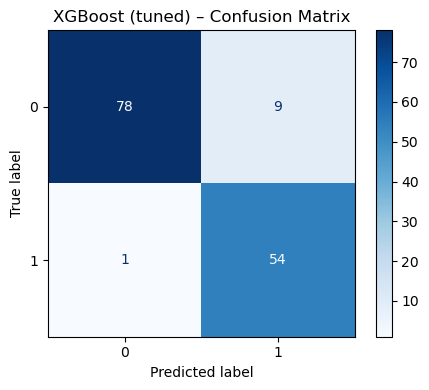


Classification report (tuned XGBoost):
              precision    recall  f1-score   support

           0       0.99      0.90      0.94        87
           1       0.86      0.98      0.92        55

    accuracy                           0.93       142
   macro avg       0.92      0.94      0.93       142
weighted avg       0.94      0.93      0.93       142



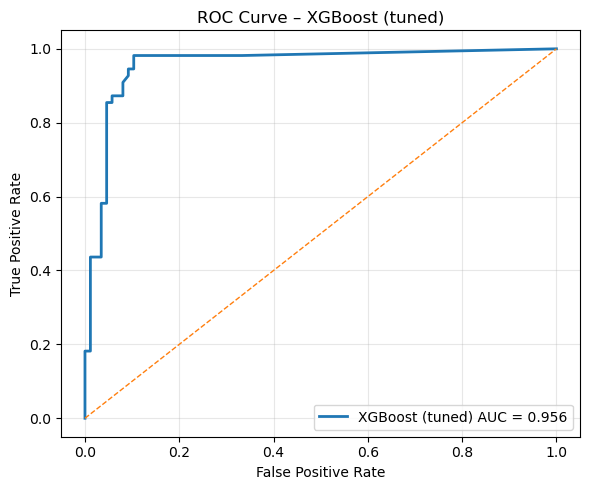

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sqlalchemy import create_engine
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    roc_auc_score,
    roc_curve,
    confusion_matrix,
    ConfusionMatrixDisplay,
    classification_report,
)

from xgboost import XGBClassifier

db_path = "data/org_compliance_data.db"
engine = create_engine(f"sqlite:///{db_path}")

try:
    df
    print("DataFrame zaten yüklü, yeniden yüklenmedi.")
except NameError:
    print("Loading 'departments' table from database...")
    df = pd.read_sql("SELECT * FROM departments", engine)

print("Dataset shape:", df.shape)
display(df.head())


threshold = 70.0
df["risk_flag"] = (df["compliance_score_final"] < threshold).astype(int)

print("Target distribution (risk_flag):")
print(df["risk_flag"].value_counts(normalize=True))


categorical_features = df.select_dtypes(include=["object"]).columns.tolist()

numeric_features = [
    "dept_age_years",
    "manager_experience_level",
    "supervisor_experience_level",
    "reporting_lag_days",
    "training_hours_quarterly",
    "violations_past_3years",
    "remediation_plan_active",
    "executive_support",
    "external_consulting",
    "engagement_programs",
    "onboarding_program",
    "improvement_commitment",
    "digital_systems",
    "external_partnerships",
    "interdept_collaboration_score",
    "resource_availability_score",
    "external_interactions_frequency",
    "risk_exposure_operational",
    "risk_exposure_financial",
    "operational_health_index",
    "reporting_gaps_annual",
    "audit_score_q1",
    "audit_score_q2",
    "overall_risk_score",
]

print("Categorical features:", categorical_features)
print("Numeric features:", numeric_features)

X = df[categorical_features + numeric_features]
y = df["risk_flag"]

X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    test_size=0.2,
    random_state=42,
    stratify=y
)

print("Train size:", X_train.shape, "Test size:", X_test.shape)

preprocessor = ColumnTransformer(
    transformers=[
        ("cat", OneHotEncoder(handle_unknown="ignore"), categorical_features),
        ("num", "passthrough", numeric_features),
    ]
)

def compute_metrics(model, X_test, y_test, model_name="model"):
    """Accuracy, precision, recall, F1 ve ROC-AUC hesapla."""
    y_pred = model.predict(X_test)
    if hasattr(model, "predict_proba"):
        y_proba = model.predict_proba(X_test)[:, 1]
    else:
    
        y_proba = None

    acc = accuracy_score(y_test, y_pred)
    prec = precision_score(y_test, y_pred, zero_division=0)
    rec = recall_score(y_test, y_pred, zero_division=0)
    f1 = f1_score(y_test, y_pred, zero_division=0)

    if y_proba is not None:
        auc = roc_auc_score(y_test, y_proba)
    else:
        auc = np.nan

    print(f"\n=== {model_name} performance ===")
    print("Accuracy :", acc)
    print("Precision:", prec)
    print("Recall   :", rec)
    print("F1-score :", f1)
    if not np.isnan(auc):
        print("ROC-AUC  :", auc)

    return {
        "accuracy": acc,
        "precision": prec,
        "recall": rec,
        "f1": f1,
        "auc": auc,
    }


xgb_baseline = XGBClassifier(
    random_state=42,
    n_estimators=100,
    learning_rate=0.1,
    max_depth=3,
    subsample=1.0,
    colsample_bytree=1.0,
    eval_metric="logloss",
)

xgb_pipeline = Pipeline(
    steps=[
        ("preprocessor", preprocessor),
        ("model", xgb_baseline),
    ]
)

xgb_pipeline.fit(X_train, y_train)
xgb_baseline_metrics = compute_metrics(
    xgb_pipeline, X_test, y_test, model_name="XGBoost baseline"
)


param_grid = {
    "model__n_estimators": [100, 200, 300],
    "model__max_depth": [3, 4, 5],
    "model__learning_rate": [0.01, 0.05, 0.1],
}

xgb = XGBClassifier(
    random_state=42,
    subsample=1.0,
    colsample_bytree=1.0,
    eval_metric="logloss",
)

xgb_pipeline_tuning = Pipeline(
    steps=[
        ("preprocessor", preprocessor),
        ("model", xgb),
    ]
)

grid_search = GridSearchCV(
    estimator=xgb_pipeline_tuning,
    param_grid=param_grid,
    scoring="f1",
    cv=5,
    n_jobs=-1,
    verbose=1,
)

grid_search.fit(X_train, y_train)

print("\nBest parameters for XGBoost:", grid_search.best_params_)

xgb_model_tuned = grid_search.best_estimator_
xgb_tuned_metrics = compute_metrics(
    xgb_model_tuned, X_test, y_test, model_name="XGBoost tuned"
)

y_pred_tuned = xgb_model_tuned.predict(X_test)
cm = confusion_matrix(y_test, y_pred_tuned)

fig, ax = plt.subplots(figsize=(5, 4))
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[0, 1])
disp.plot(ax=ax, cmap="Blues")
ax.set_title("XGBoost (tuned) – Confusion Matrix")
plt.tight_layout()
plt.show()

print("\nClassification report (tuned XGBoost):")
print(classification_report(y_test, y_pred_tuned))

y_proba_tuned = xgb_model_tuned.predict_proba(X_test)[:, 1]
fpr, tpr, thresholds = roc_curve(y_test, y_proba_tuned)
auc_value = roc_auc_score(y_test, y_proba_tuned)

plt.figure(figsize=(6, 5))
plt.plot(fpr, tpr, label=f"XGBoost (tuned) AUC = {auc_value:.3f}", linewidth=2)
plt.plot([0, 1], [0, 1], linestyle="--", linewidth=1)
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve – XGBoost (tuned)")
plt.legend(loc="lower right")
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

## 1. Data Loading

We load the SQLite database `org_compliance_data.db` from the `data/` folder and inspect the available tables.

## 2. Exploratory Data Analysis (EDA)

_Teammate A:_ add histograms, boxplots, counts, and correlation heatmaps here once `df` is defined.

In [2]:
# Example EDA template (uncomment once df is defined)
# display(df.head())
# display(df.describe(include="all"))

# numeric_cols = df.select_dtypes(include=["int64", "float64"]).columns
# df[numeric_cols].hist(bins=30, figsize=(12, 8))
# plt.tight_layout()
# plt.show()

# corr = df[numeric_cols].corr()
# sns.heatmap(corr, annot=False, cmap="coolwarm")
# plt.title("Correlation heatmap")
# plt.show()


## 3. Preprocessing & Feature Engineering

Here we define:
- target variable `y`
- feature matrix `X`
- train/test split
- scaling/imputation if needed.

In [3]:
# Example template – adapt based on your actual columns
# target_col = "<TARGET_COLUMN_NAME>"  # TODO: replace with real target name
# feature_cols = [c for c in df.columns if c != target_col]

# X = df[feature_cols]
# y = df[target_col]

# X_train, X_test, y_train, y_test = train_test_split(
#     X, y, test_size=0.2, random_state=42, stratify=y
# )

# scaler = StandardScaler()
# X_train_scaled = scaler.fit_transform(X_train)
# X_test_scaled = scaler.transform(X_test)


## 4. Model Training & Cross-Validation

Here we train at least 3 models: Logistic Regression, Random Forest, XGBoost.

_You (Petra) handle this part._

In [4]:
# Example placeholder – replace with real code once X_train_scaled / y_train exist

# log_reg = LogisticRegression(max_iter=1000)
# rf = RandomForestClassifier(random_state=42)
# xgb = XGBClassifier(random_state=42, eval_metric="logloss")

# models = {
#     "Logistic Regression": log_reg,
#     "Random Forest": rf,
#     "XGBoost": xgb
# }

# results = []
# for name, model in models.items():
#     model.fit(X_train_scaled, y_train)
#     y_pred = model.predict(X_test_scaled)
#     y_proba = model.predict_proba(X_test_scaled)[:, 1]

#     acc = accuracy_score(y_test, y_pred)
#     prec = precision_score(y_test, y_pred)
#     rec = recall_score(y_test, y_pred)
#     f1 = f1_score(y_test, y_pred)
#     auc = roc_auc_score(y_test, y_proba)

#     results.append([name, acc, prec, rec, f1, auc])

# results_df = pd.DataFrame(results, columns=["Model", "Accuracy", "Precision", "Recall", "F1", "AUC"])
# display(results_df)


XGBoost + Interpretability (Koray)

 4.x XGBoost – Baseline vs Tuned Model (Summary)

We framed the problem as a **binary risk classification** task.  
The target variable `risk_flag` was created from the final compliance score:

- `risk_flag = 1` if `compliance_score_final < 70` (high-risk department)  
- `risk_flag = 0` otherwise (acceptable compliance level)

We used XGBoost as our main non-linear model for tabular data, because it:
- Handles mixed numeric + categorical (after encoding) features,
- Captures complex interactions between risk factors,
- Is robust to outliers and different feature scales.

After splitting the data into **train (567 rows) and test (142 rows)** we trained:

1. **Baseline XGBoost** with default hyperparameters  
2. **Tuned XGBoost** using grid search with 5-fold cross-validation, exploring:
   - `n_estimators ∈ {100, 200, 300}`
   - `max_depth ∈ {3, 4, 5}`
   - `learning_rate ∈ {0.01, 0.05, 0.1}`

The best configuration found was:

- `n_estimators = 200`  
- `max_depth = 3`  
- `learning_rate = 0.01`

 Test performance (XGBoost)

| Model              | Accuracy | Precision | Recall | F1-score | ROC-AUC |
|--------------------|----------|-----------|--------|----------|---------|
| Baseline XGBoost   | 0.94     | 0.89      | 0.98   | 0.93     | 0.96    |
| Tuned XGBoost      | 0.93     | 0.86      | 0.98   | 0.92     | 0.96    |

Both models achieve **very high recall (~0.98)** on the test set.  
This means the model is **catching almost all high-risk departments**, which is crucial in a compliance context (we prefer to avoid false negatives).

Precision is slightly lower (~0.86–0.89), meaning that some departments flagged as “high risk” may actually be acceptable. However, this is an acceptable trade-off: in a compliance setting it is better to investigate a few extra departments than to miss a truly risky one.

Overall, the tuned XGBoost configuration offers a **balanced and robust risk-scoring model** that can be used as the main engine of the *Compliance Radar* tool.

## 5. Interpretability (Feature Importance & SHAP)

_You (Petra) also handle this part._

In [5]:
# Example placeholder – compute SHAP values for the best model
# best_model = rf  # or xgb, depending on results

# explainer = shap.TreeExplainer(best_model)
# shap_values = explainer.shap_values(X_test_scaled)

# shap.summary_plot(shap_values, X_test, feature_names=X_test.columns)


## 6. Conclusions & Compliance Insights

_Teammate B/C:_ add textual interpretation here based on the final results.

- Which features are most strongly associated with potential non-compliance?
- How should the organisation monitor these?
- What recommendations follow from the model outputs?
